In [25]:
import os
import pandas as pd
import numpy as np
import re

In [23]:

# Define the project root as the directory containing the notebook, or adjust as needed
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the path to the JSON file relative to the project root
json_file_path = os.path.join(PROJECT_ROOT, 'data', 'raw', 'combined_organizations.json')

# Load the JSON file into a pandas DataFrame
def load_json_as_dataframe(file_path):
    return pd.read_json(file_path, orient='records')

# Load the combined_organizations.json file
combined_organizations = load_json_as_dataframe(json_file_path)

# Now, combined_organizations_df contains the loaded data in a pandas DataFrame
print(combined_organizations.info())  # This will give you an overview of the data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451528 entries, 0 to 451527
Data columns (total 35 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SME                 382461 non-null  object 
 1   active              382461 non-null  object 
 2   activityType        382461 non-null  object 
 3   city                382461 non-null  object 
 4   contactForm         382461 non-null  object 
 5   contentUpdateDate   382461 non-null  object 
 6   country             382461 non-null  object 
 7   ecContribution      382461 non-null  object 
 8   endOfParticipation  382461 non-null  object 
 9   geolocation         382461 non-null  object 
 10  name                451528 non-null  object 
 11  netEcContribution   382461 non-null  object 
 12  nutsCode            382461 non-null  object 
 13  order               382461 non-null  float64
 14  organisationID      382461 non-null  object 
 15  organizationURL     382461 non-nul

In [6]:
combined_organizations.head()

,SME,active,activityType,city,contactForm,contentUpdateDate,country,ecContribution,endOfParticipation,geolocation,...,links,ext,id,outcomeid,href,created,updated,regNumber,website,addresses
0,,,REC,BRAUNSCHWEIG,https://ec.europa.eu/info/funding-tenders/oppo...,2023-03-10 20:03:22,DE,21000000,False,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,,OTH,Helsinki,https://ec.europa.eu/info/funding-tenders/oppo...,2022-09-03 22:47:18,FI,7266762.69,False,"60.1649168,24.9417059",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,,PUB,Namur,https://ec.europa.eu/info/funding-tenders/oppo...,2017-05-26 03:03:58,BE,241253,False,"50.4609727,4.8772312",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,PUB,Saint-Gilles,https://ec.europa.eu/info/funding-tenders/oppo...,2017-05-26 03:03:58,BE,,False,"50.82787664999999,4.355637753670975",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,,REC,Chatenay Malabry,https://ec.europa.eu/info/funding-tenders/oppo...,2016-10-24 10:10:05,FR,410000,False,"48.7661105,2.2781646",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

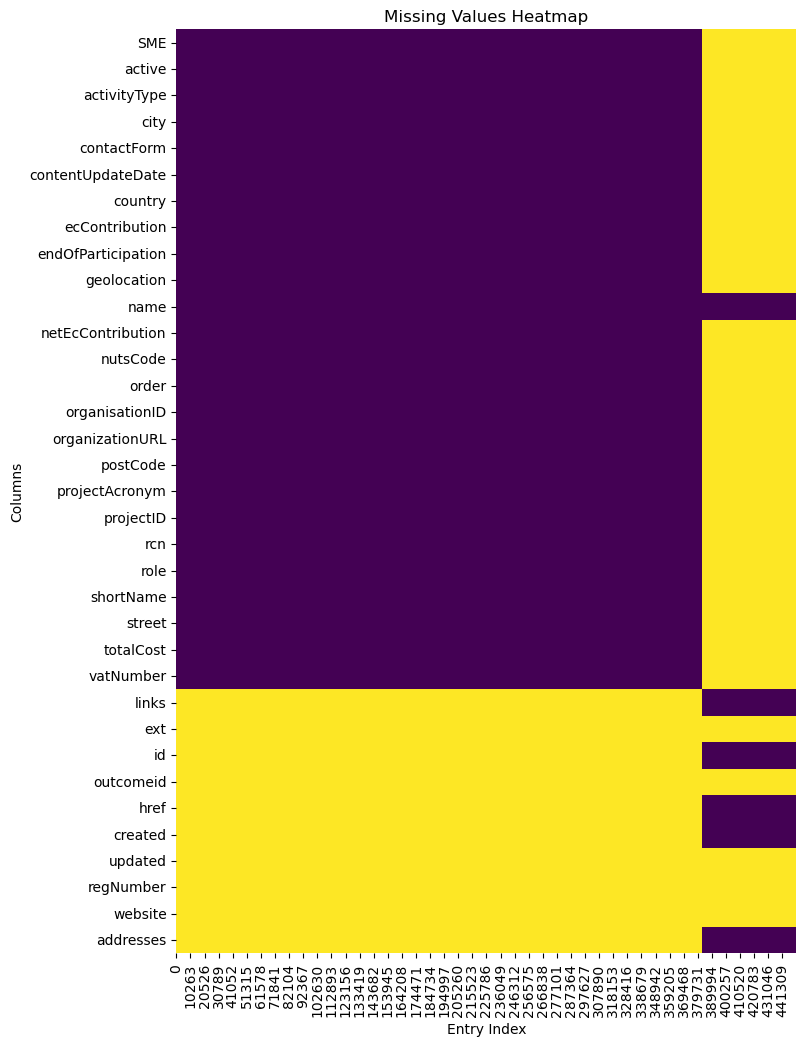

In [9]:
# Heatmap of missing values
plt.figure(figsize=(8, 12))
sns.heatmap(combined_organizations.isnull().T, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xlabel('Entry Index')
plt.ylabel('Columns')
plt.show()


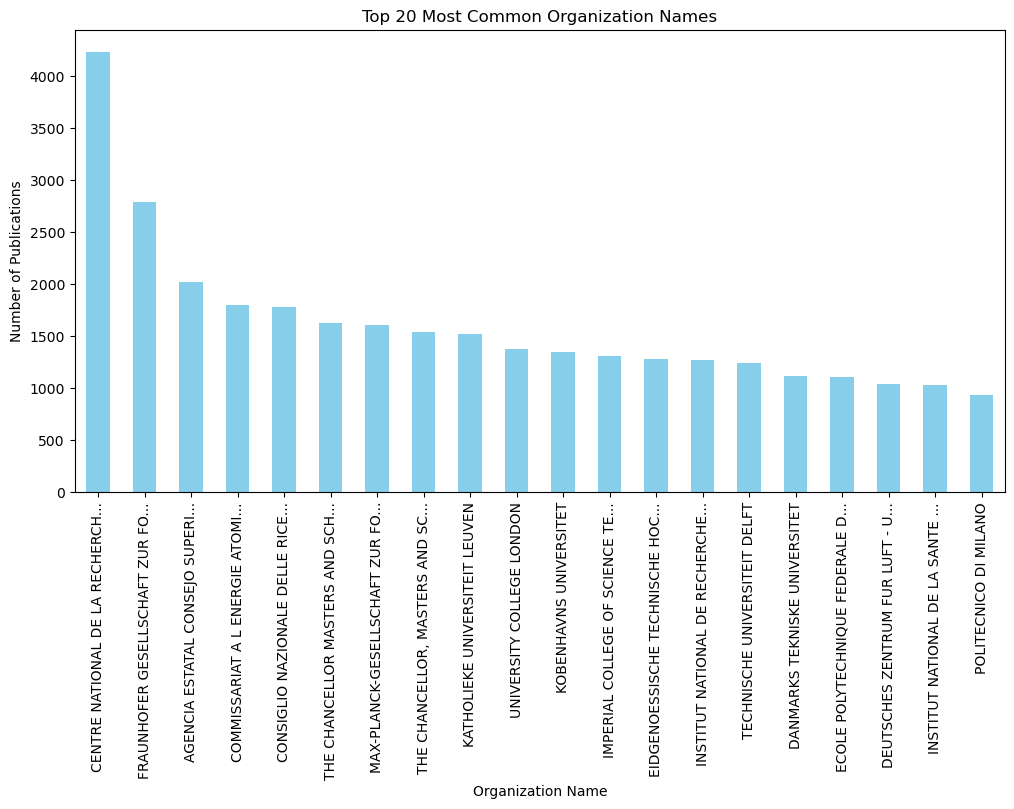

In [22]:
# Truncate long organization names for better readability
def truncate_name(name, length=30):
    name = str(name)  # Convert to string
    if len(name) > length:
        return name[:length] + '...'
    else:
        return name

# Apply truncation to the 'name' column
combined_organizations['short_name'] = combined_organizations['name'].apply(truncate_name)

# Top 20 most common organization names with truncated labels
plt.figure(figsize=(12, 6))
combined_organizations['short_name'].value_counts().head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Common Organization Names')
plt.xlabel('Organization Name')
plt.ylabel('Number of Publications')
plt.xticks(rotation=90)
plt.show()


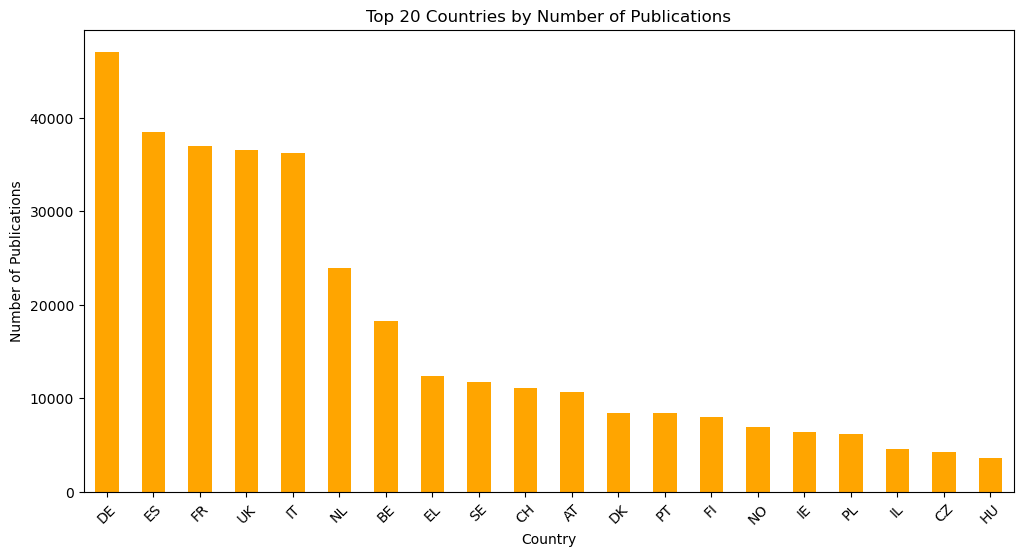

In [18]:
# Number of publications by country
plt.figure(figsize=(12, 6))
combined_organizations['country'].value_counts().head(20).plot(kind='bar', color='orange')
plt.title('Top 20 Countries by Number of Publications')
plt.xlabel('Country')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.show()


In [27]:

# Improved standardize function
def standardize_name(name):
    name = str(name).lower()  # Convert to lowercase
    name = re.sub(r'[^\w\s]', '', name)  # Remove punctuation
    name = re.sub(r'\b(limited|inc|ltd|gmbh|sa|co|corporation|corp|llc|plc)\b', '', name)  # Remove common legal entity suffixes
    name = re.sub(r'\b(the|of|and)\b', '', name)  # Remove common connecting words
    name = re.sub(r'\s+', ' ', name).strip()  # Remove extra spaces
    return name

# Apply standardization
combined_organizations['standardized_name'] = combined_organizations['name'].apply(standardize_name)

# Display the first few rows to check the result
combined_organizations[['name', 'standardized_name']].head()


,name,standardized_name
0,EURAMET EV - EUROPEAN ASSOCIATION OF NATIONAL ...,euramet ev european association national metro...
1,BALTIC ORGANISATIONS NETWORK FOR FUNDING SCIEN...,baltic organisations network for funding scien...
2,SERVICE PUBLIC DE WALLONIE,service public de wallonie
3,INNOVIRIS,innoviris
4,AGENCE NATIONALE POUR LA GESTION DES DECHETS R...,agence nationale pour la gestion des dechets r...


In [29]:
len(combined_organizations['standardized_name'].unique())

127049

In [31]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering

# Sample the data for demonstration purposes
sampled_names = combined_organizations['standardized_name'].sample(n=5000, random_state=42).unique()

# Vectorize the organization names
vectorizer = TfidfVectorizer().fit_transform(sampled_names)

# Perform clustering with the updated metric parameter
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0, metric='cosine', linkage='complete').fit(vectorizer.toarray())

# Assign cluster labels
cluster_labels = clustering.labels_

# Create a DataFrame with the results
clustered_names = pd.DataFrame({'name': sampled_names, 'cluster': cluster_labels})

# Group by clusters to find similar names
grouped_clusters = clustered_names.groupby('cluster')['name'].apply(list).reset_index()

# Filter out clusters with only one organization (i.e., no potential duplicates)
potential_duplicates = grouped_clusters[grouped_clusters['name'].apply(len) > 1]

# Display the first few clusters with potential duplicates
potential_duplicates.head(10)



,cluster,name
0,0,[fundacion circe centro de investigacion de re...
1,1,[erevnitiko panepistimiako institouto systimat...
2,2,[centro de neurociencias e biologiacelular ass...
3,3,[iclei european secretariat iclei europasekret...
4,4,"[aberystwyth university, university edinburgh,..."
5,5,[comissao de coordenacao e desenvolvimento reg...
6,6,[icleilocal governments for sustainabilityafri...
7,7,"[cesie ente del terzo settore, agenzia regiona..."
8,8,[ministrstvo za kmetijstvo gozdarstvo in prehr...
9,9,[zurcher hochschule fur angewandte wissenschaf...


In [32]:
# Function to visualize clusters
def visualize_clusters(cluster_df, num_clusters=10):
    cluster_df = cluster_df.head(num_clusters)
    for idx, row in cluster_df.iterrows():
        print(f"Cluster {row['cluster']}:")
        for name in row['name']:
            print(f" - {name}")
        print("\n" + "-"*40 + "\n")

# Visualize the top 10 clusters with potential duplicates
visualize_clusters(potential_duplicates, num_clusters=10)


Cluster 0:
 - fundacion circe centro de investigacion de recursos y consumos energeticos
 - centre de recerca en agrigenomica csicirtauabub
 - universidad politecnica de madrid
 - agence nationale de protection de lenvironnement
 - juguettos central de compras scoop
 - aprenassociacao portuguesa de energias renovaveis
 - universitat politecnica de valencia
 - centro de investigaciones energeticas medioambientales y tecnologicas
 - centre tecnologic de telecomunicacions de catalunya
 - instituto nacional de tecnica aeroespacial esteban terradas
 - fundacion instituto de estudios de ciencias de la salud de castilla y leon
 - ayuntamiento de valladolid
 - instituto nacional de saude dr ricardo jorge
 - socib consorcio para el diseno construccion equipamiento y explotacion del sistema de observacion costero de las illes balears
 - cluster de salud de castilla y leon
 - universite de bretagne occidentale
 - instituto de biomecanica de valencia
 - unidade local de saude do alentejo central e

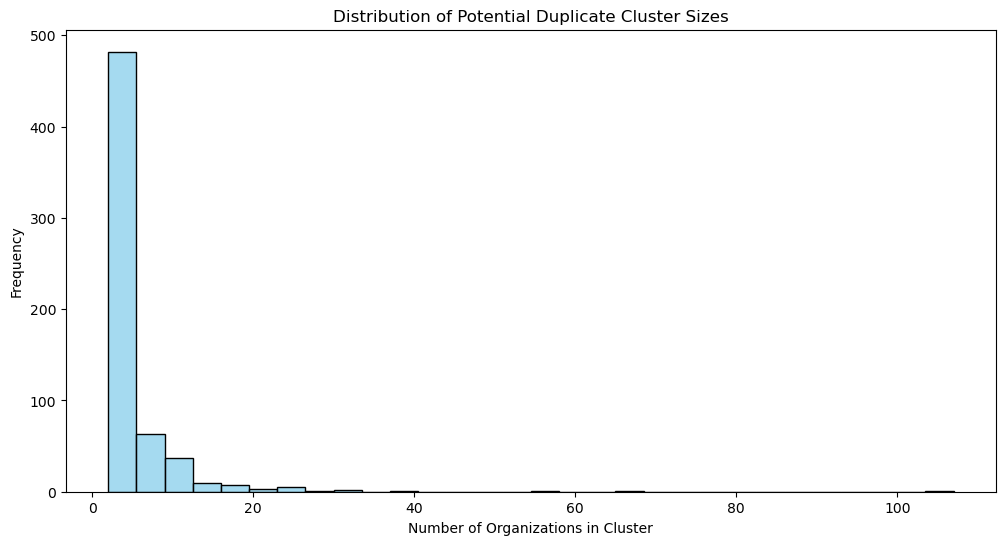

In [33]:
# Plotting the distribution of cluster sizes
plt.figure(figsize=(12, 6))
sns.histplot(potential_duplicates['name'].apply(len), bins=30, kde=False, color='skyblue')
plt.title('Distribution of Potential Duplicate Cluster Sizes')
plt.xlabel('Number of Organizations in Cluster')
plt.ylabel('Frequency')
plt.show()


In [37]:
# Group by 'organisationID' and count the number of unique names
org_name_counts = combined_organizations.groupby('organisationID')['name'].nunique()

# Filter to find organisationIDs with more than one unique name
multiple_names_orgs = org_name_counts[org_name_counts > 1]

# Display the result
multiple_names_orgs = multiple_names_orgs.reset_index()
multiple_names_orgs.columns = ['organisationID', 'unique_name_count']
print(f"Number of organisationIDs with more than one unique name: {len(multiple_names_orgs)}")
multiple_names_orgs.head(10)


Number of organisationIDs with more than one unique name: 3


,organisationID,unique_name_count
0,958588436,2
1,998399661,2
2,,396


In [39]:
# Ensure 'organisationID' is treated as a string for consistent comparison
combined_organizations['organisationID'] = combined_organizations['organisationID'].astype(str)

# Filter the DataFrame to get the entries for the two specific organisationIDs
orgs_with_dupes_filtered = combined_organizations[combined_organizations['organisationID'].isin(['958588436', '998399661'])]

# Print out the organization names associated with each ID
for org_id in ['958588436', '998399661']:
    org_names = orgs_with_dupes_filtered[orgs_with_dupes_filtered['organisationID'] == org_id]['name'].unique()
    print(f"OrganisationID: {org_id}")
    for name in org_names:
        print(f" - {name}")
    print("\n" + "-"*40 + "\n")


OrganisationID: 958588436
 - ZIM PLANT TECHNOLOGY GMBH
 - VARDA GERMANY GMBH

----------------------------------------

OrganisationID: 998399661
 - MAAT FRANCE SARL
 - BE YS RESEARCH FRANCE

----------------------------------------

